# Intro

TPOT gives the user a lot of options for customizing the search space, from hyperparameter ranges to model selection to pipeline configuration. TPOT is able to select models, optimize their hyperparameters, as well as build a complex pipeline structure. Each level of detail has multiple options for customization. In this tutorial, first we will explore how to set up a hyperparameter search space for a single method. Next we will describe how to set up simultaneous model selection and hyperparameter tuning. And finally we will cover how to utilize these steps to configure a search space for a fixed pipeline of multiple steps as well as having TPOT optimize the pipeline structure itself.


# Hyperparameter Search Spaces with ConfigSpace

Hyperparameter search spaces are defined using the [ConfigSpace package found here](https://github.com/automl/ConfigSpace). More information on how to set up a hyperparameter space can be found in their [documentation here](https://automl.github.io/ConfigSpace/main/guide.html).

TPOT uses `ConfigSpace.ConfigurationSpace` objects to define the hyperparameter search space for individual models. This object can be used to keep track of the desired hyperparameters as well as provide functions for randomly sampling from this space.

In short, you can use the `Integer`, `Float`, and `Categorical` functions of `ConfigSpace` to define a range of values used for each param. Alternatively, a tuple with (min,max) ints or floats can be used to specify a int/float search space, and a list is used to specify a categorical search space. A fixed value an also be provided for parameters that are not tunned. The space parameter of `ConfigurationSpace` takes in a dictionary of param name to these ranges.

Note: If you want results to be reproducible, you need set a fixed random_state in the search space.

Here is an example of a hyperparameter range for RandomForest

In [1]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, Normal
from sklearn.ensemble import RandomForestClassifier
import tpot2
import numpy as np
import sklearn
import sklearn.datasets

rf_configspace = ConfigurationSpace(
    space = {
            'n_estimators': 128, #as recommended by Oshiro et al. (2012
            'max_features': Float("max_features", bounds=(0.01,1), log=True), #log scale like autosklearn?
            'criterion': Categorical("criterion", ['gini', 'entropy']),
            'min_samples_split': Integer("min_samples_split", bounds=(2, 20)),
            'min_samples_leaf': Integer("min_samples_leaf", bounds=(1, 20)),
            'bootstrap': Categorical("bootstrap", [True, False]),
            #random_state = 1, # If you want results to be reproducible, you can set a fixed random_state.
        }
)

hyperparameters = dict(rf_configspace.sample_configuration())
print("sampled hyperparameters")
print(hyperparameters)

rf = RandomForestClassifier(**hyperparameters)
rf

sampled hyperparameters
{'bootstrap': False, 'criterion': 'gini', 'max_features': 0.0109527542096, 'min_samples_leaf': 15, 'min_samples_split': 4, 'n_estimators': 128}


RandomForestClassifier(bootstrap=False, max_features=0.0109527542096,
                       min_samples_leaf=15, min_samples_split=4,
                       n_estimators=128)

More simply:

In [2]:
rf_configspace = ConfigurationSpace(
    space = {
            'n_estimators': 128, #as recommended by Oshiro et al. (2012
            'max_features':(0.01,1), #not log scaled
            'criterion': ['gini', 'entropy'],
            'min_samples_split': (2, 20),
            'min_samples_leaf': (1, 20),
            'bootstrap': [True, False],
            #random_state = 1, # If you want results to be reproducible, you can set a fixed random_state.
        }
)

hyperparameters = dict(rf_configspace.sample_configuration())
print("sampled hyperparameters")
print(hyperparameters)

rf = RandomForestClassifier(**hyperparameters)
rf

sampled hyperparameters
{'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.8366498702446, 'min_samples_leaf': 11, 'min_samples_split': 20, 'n_estimators': 128}


RandomForestClassifier(criterion='entropy', max_features=0.8366498702446,
                       min_samples_leaf=11, min_samples_split=20,
                       n_estimators=128)

# TPOT Search spaces

TPOT allows you to both hyperparameter search spaces for individual methods as well as pipeline structure search spaces. For example, TPOT can create linear pipelines, trees, or graphs. 

TPOT search spaces are found in the `search_spaces` module. There are two primary kinds of search spaces, node and pipeline. Node search spaces specify the search space of a single sklearn `BaseEstimator`. Pipeline search spaces define the possible structures for a group of node search spaces. These take in node search spaces and produce a pipeline using nodes from that search space. Since sklearn Pipelines are also `BaseEstimator`, pipeline search spaces are also technically node search spaces. Meaning that pipeline search spaces can take in other pipeline search spaces in order to define more complex structures. The primary differentiating factor bewteen node and pipeline search spaces is that pipeline search spaces must take in another search space as input to feed its individual nodes. Therefore, all search spaces eventually end in a node search space at the lowest level. Note that parameters for pipeline search spaces can differ, some take in only a single search space, some take in a list, or some take in multiple defined parameters.

## node search spaces


| Name      | Info       |
| :---        |    :----:   |
| EstimatorNode | Takes in a ConfigSpace along with the class of the method. This node will optimize the hyperparameters for a single method. |
| GeneticFeatureSelectorNode | Uses evolution to optimize a set of features, exports a basic sklearn Selector that simply selects the features chosen by the node. |
| FSSNode | FSS stands for FeatureSetSelector. This node takes in a list of user-defined subsets of features and selects a single predefined subset. Note that TPOT will not create new subsets nor will it select multiple subsets per node. If using a linear pipeline, this node should be set as the first step. In linear pipelines it is recommended that you only use a small number of feature sets. I recommend exploring using FSSNodes in pipelines that allow TPOT to select more than one FSSNode at a time. For example, DynamicUnionPipeline and GraphPipeline are both excellent combos for FSSNode. Use FFSNode inside a DynamicUnionPipeline at the start of linear pipeline to explore optimal combinations of subsets in linear pipelines. Set the leaf_search_space of GraphSearchPipeline TPOT can use multiple feature sets in different ways, for example, with different transformers for different sets. |



## pipeline search spaces

found in tpot2.search_spaces.pipelines

WrapperPipeline -         This search space is for wrapping a sklearn estimator with a method that takes another estimator and hyperparameters as arguments.
        For example, this can be used with sklearn.ensemble.BaggingClassifier or sklearn.ensemble.AdaBoostClassifier.


| Name      | Info       |
| :---        |    :----:   |
| ChoicePipeline | Takes in a list of search spaces. Will select one node from the search space. |
| SequentialPipeline | Takes in a list of search spaces. will produce a pipeline of Sequential length. Each step in the pipeline will correspond to the the search space provided in the same index. |
| DynamicLinearPipeline | Takes in a single search space. Will produce a linear pipeline of variable length. Each step in the pipeline will be pulled from the search space provided. |
| UnionPipeline | Takes in a list of search spaces. The returned pipeline will include one estimator per search space joined in an sklearn FeatureUnion. Useful for having many steps in one layer.  |
| DynamicUnionPipeline | Takes in a single search space. It will pull anywhere from 1 to max_estimators number of estimators from the search space and concatenate them in a FeatureUnion. |
| TreePipeline |Generates a pipeline of variable length. Pipeline will have a tree structure similar to TPOT1. |
| GraphSearchPipeline | Generates a directed acyclic graph of variable size. Search spaces for root, leaf, and inner nodes can be defined separately if desired. |
| WrapperPipeline   | This search space is for wrapping a sklearn estimator with a method that takes another estimator and hyperparameters as arguments. For example, this can be used with sklearn.ensemble.BaggingClassifier or sklearn.ensemble.AdaBoostClassifier.        |


## Node Search Space Examples

Node search spaces represent the smallest unit of an sklearn pipeline. All node search spaces create and optimize a single node, or estimator object. For example this could be a KNeighborsClassifier or a FeatureSetSelector.

### EstimatorNode

The EstimatorNode represents the hyperparameter search space for a scikit-learn estimator. 

Note that `ConfigSpace` doesn't support `None` in its search space, and does not support the booleans True or False as fixed parameters (though booleans seem to be allowed in Categorical search spaces). To get around this, use the macros defined in:

`from tpot2.search_spaces.nodes.estimator_node import NONE_SPECIAL_STRING, TRUE_SPECIAL_STRING, FALSE_SPECIAL_STRING`

In [3]:
import tpot2
from ConfigSpace import ConfigurationSpace
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, Normal
from sklearn.neighbors import KNeighborsClassifier

knn_configspace = ConfigurationSpace(
    space = {

        'n_neighbors': Integer("n_neighbors", bounds=(1, 10)),
        'weights': Categorical("weights", ['uniform', 'distance']),
        'p': Integer("p", bounds=(1, 3)),
        'metric': Categorical("metric", ['euclidean', 'minkowski']),
        'n_jobs': 1,
    }
)


knn_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = KNeighborsClassifier,
    space = knn_configspace,
)

You can sample generate an individual with the generate() function. This individual samples from the search space as well as provides mutation and crossover functions to modify the current sample.

In [4]:
knn_individual = knn_node.generate()
knn_individual

In [5]:
print("sampled hyperparameters")
print(knn_individual.hyperparameters)

sampled hyperparameters
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}


All Individual objects have mutation and crossover operators that TPOT uses to optimize the pipelines.

In [6]:
knn_individual.mutate() # mutate the individual
print("mutated hyperparameters")
print(knn_individual.hyperparameters)

mutated hyperparameters
{'metric': 'minkowski', 'n_jobs': 1, 'n_neighbors': 1, 'p': 3, 'weights': 'distance'}


In TPOT2, crossover only modifies the individual calling the crossover function, the second individual remains the same

In [7]:
knn_individual1 = knn_node.generate()
knn_individual2 = knn_node.generate()

print("original hyperparameters for individual 1")
print(knn_individual1.hyperparameters)

print("original hyperparameters for individual 2")
print(knn_individual2.hyperparameters)

print()

knn_individual1.crossover(knn_individual2) # crossover the individuals
print("post crossover hyperparameters for individual 1")
print(knn_individual1.hyperparameters)
print("post crossover hyperparameters for individual 2")
print(knn_individual2.hyperparameters)



original hyperparameters for individual 1
{'metric': 'minkowski', 'n_jobs': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
original hyperparameters for individual 2
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 7, 'p': 3, 'weights': 'distance'}

post crossover hyperparameters for individual 1
{'metric': 'minkowski', 'n_jobs': 1, 'n_neighbors': 8, 'p': 3, 'weights': 'uniform'}
post crossover hyperparameters for individual 2
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 7, 'p': 3, 'weights': 'distance'}


All search spaces have an export_pipeline function that returns an sklearn `BaseEstimator`

In [8]:
est = knn_individual1.export_pipeline()
est

KNeighborsClassifier(n_jobs=1, n_neighbors=8, p=3)

If a dictionary of parameters is passed instead of of a ConfigSpace object, then the hyperparameters will always be fixed and not learned.

In [9]:
import tpot2
from ConfigSpace import ConfigurationSpace
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, Normal
from sklearn.neighbors import KNeighborsClassifier

space = {

    'n_neighbors':10,
}

knn_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = KNeighborsClassifier,
    space = space,
)

knn_node.generate().export_pipeline()

KNeighborsClassifier(n_neighbors=10)

### FSSNode and GeneticFeatureSelectorNode

Both of these are given their own tutorials. See Tutorial 3 for FFSNode and Tutorial 5 for GeneticFeatureSelectorNode

## Pipeline Search Space Examples

Pipeline search spaces are used to define the structure and restrictions of the pipelines TPOT can search. Unlike Node search spaces, all pipeline search spaces take in other search spaces as inputs. Rather than sample hyperparameters, pipeline search spaces can select models from the input search spaces and organize them within a linear sklearn Pipeline or a TPOT GraphPipeline.

### ChoicePipeline

The simplest pipeline search space is the ChoicePipeline. This takes in a list of search spaces and simply selects and samples from one. In this example, we will construct a search space that takes in several options for a classifier. The resulting search space will then first select a model from KNeighborsClassifier, LogisticRegression or DecisionTreeClassifier, and then select the hyperparameters for the given model.

In [10]:
import tpot2
from ConfigSpace import ConfigurationSpace
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, Normal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

knn_configspace = ConfigurationSpace(
    space = {

        'n_neighbors': Integer("n_neighbors", bounds=(1, 10)),
        'weights': Categorical("weights", ['uniform', 'distance']),
        'p': Integer("p", bounds=(1, 3)),
        'metric': Categorical("metric", ['euclidean', 'minkowski']),
        'n_jobs': 1,
    }
)

lr_configspace = ConfigurationSpace(
        space = {
            'solver': Categorical("solver", ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
            'penalty': Categorical("penalty", ['l1', 'l2']),
            'dual': Categorical("dual", [True, False]),
            'C': Float("C", bounds=(1e-4, 1e4), log=True),
            'class_weight': Categorical("class_weight", ['balanced']),
            'n_jobs': 1,
            'max_iter': 1000,
        }
    )

dt_configspace = ConfigurationSpace(
        space = {
            'criterion': Categorical("criterion", ['gini', 'entropy']),
            'max_depth': Integer("max_depth", bounds=(1, 11)),
            'min_samples_split': Integer("min_samples_split", bounds=(2, 21)),
            'min_samples_leaf': Integer("min_samples_leaf", bounds=(1, 21)),
            'max_features': Categorical("max_features", ['sqrt', 'log2']),
            'min_weight_fraction_leaf': 0.0,
        }
    )

knn_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = KNeighborsClassifier,
    space = knn_configspace,
)

lr_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = LogisticRegression,
    space = lr_configspace,
)

dt_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = DecisionTreeClassifier,
    space = dt_configspace,
)

classifier_node = tpot2.search_spaces.pipelines.ChoicePipeline(
    search_spaces=[
        knn_node,
        lr_node,
        dt_node,
    ]
)


tpot2.search_spaces.pipelines.ChoicePipeline(
    search_spaces = [
        tpot2.search_spaces.nodes.EstimatorNode(
            method = KNeighborsClassifier,
            space = knn_configspace,
            ),
        tpot2.search_spaces.nodes.EstimatorNode(
            method = LogisticRegression,
            space = lr_configspace,
        ),
        tpot2.search_spaces.nodes.EstimatorNode(
            method = DecisionTreeClassifier,
            space = dt_configspace,
        ),
    ]
)

Search space objects provided by pipeline search spaces work the same as with node search spaces. Note that crossover only works when both individuals have sampled the same method. 

In [11]:
classifier_individual = classifier_node.generate()

print("sampled pipeline")
classifier_individual.export_pipeline()

sampled pipeline


LogisticRegression(C=49.6823706295106, class_weight='balanced', dual=True,
                   max_iter=1000, n_jobs=1, solver='liblinear')

In [12]:
print("mutated pipeline")
classifier_individual.mutate()
classifier_individual.export_pipeline()

mutated pipeline


LogisticRegression(C=997.5163561212358, class_weight='balanced', dual=True,
                   max_iter=1000, n_jobs=1, solver='newton-cg')

TPOT2 also comes with predefined search spaces. The current search spaces were adapted from a combination of the original TPOT package as well as the search spaces used in [AutoSklearn](https://github.com/automl/auto-sklearn/tree/development/autosklearn/pipeline/components). The helper function `tpot2.config.get_search_space` takes in a string or a list of strings, and returns either a EstimatorNode or a ChoicePipeline,respectively. 

strings can correspond to individual methods. There are also special strings that return predefined lists of methods. 

| Special String     | Included methods      |
| :---        |    :----:   |
| "selectors" | ["SelectFwe", "SelectPercentile", "VarianceThreshold",] |
| "selectors_classification" | ["SelectFwe", "SelectPercentile", "VarianceThreshold", "RFE_classification", "SelectFromModel_classification"] |
| "selectors_regression" | ["SelectFwe", "SelectPercentile", "VarianceThreshold", "RFE_regression", "SelectFromModel_regression"] |
| "classifiers"  | ["LGBMClassifier", "BaggingClassifier", 'AdaBoostClassifier', 'BernoulliNB', 'DecisionTreeClassifier', 'ExtraTreesClassifier', 'GaussianNB', 'HistGradientBoostingClassifier', 'KNeighborsClassifier','LinearDiscriminantAnalysis', 'LogisticRegression', "LinearSVC", "SVC", 'MLPClassifier', 'MultinomialNB',  "QuadraticDiscriminantAnalysis", 'RandomForestClassifier', 'SGDClassifier', 'XGBClassifier'] |
| "regressors" | ["LGBMRegressor", 'AdaBoostRegressor', "ARDRegression", 'DecisionTreeRegressor', 'ExtraTreesRegressor', 'HistGradientBoostingRegressor', 'KNeighborsRegressor',  'LinearSVR', "MLPRegressor", 'RandomForestRegressor', 'SGDRegressor', 'SVR', 'XGBRegressor'] |
| "transformers" |  ["PassKBinsDiscretizer", "Binarizer", "PCA", "ZeroCount", "ColumnOneHotEncoder", "FastICA", "FeatureAgglomeration", "Nystroem", "RBFSampler", "QuantileTransformer", "PowerTransformer"] |
| "scalers" | ["MinMaxScaler", "RobustScaler", "StandardScaler", "MaxAbsScaler", "Normalizer", ] |
| "all_transformers" | ["transformers", "scalers"] |
| "arithmatic" | ["AddTransformer", "mul_neg_1_Transformer", "MulTransformer", "SafeReciprocalTransformer", "EQTransformer", "NETransformer", "GETransformer", "GTTransformer", "LETransformer", "LTTransformer", "MinTransformer", "MaxTransformer"] |
| "imputers" | ["SimpleImputer", "IterativeImputer", "KNNImputer"] |
| "skrebate" | ["ReliefF", "SURF", "SURFstar", "MultiSURF"] |
| "genetic_encoders" | ["DominantEncoder", "RecessiveEncoder", "HeterosisEncoder", "UnderDominanceEncoder", "OverDominanceEncoder"] |
| "classifiers_sklearnex" | ["RandomForestClassifier_sklearnex", "LogisticRegression_sklearnex", "KNeighborsClassifier_sklearnex", "SVC_sklearnex","NuSVC_sklearnex"] |
| "regressors_sklearnex" | ["LinearRegression_sklearnex", "Ridge_sklearnex", "Lasso_sklearnex", "ElasticNet_sklearnex", "SVR_sklearnex", "NuSVR_sklearnex", "RandomForestRegressor_sklearnex", "KNeighborsRegressor_sklearnex"] |

In [13]:
#same pipeline search space as before.
classifier_choice = tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"])

print("sampled pipeline 1")
classifier_choice.generate().export_pipeline()

sampled pipeline 1


LogisticRegression(C=2532.59836574515, class_weight='balanced', max_iter=1000,
                   n_jobs=1, penalty='l1', solver='saga')

In [14]:
print("sampled pipeline 2")
classifier_choice.generate().export_pipeline()

sampled pipeline 2


DecisionTreeClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=4)

In [15]:
#search space for all classifiers
classifier_choice = tpot2.config.get_search_space("classifiers")

print("sampled pipeline 1")
classifier_choice.generate().export_pipeline()

sampled pipeline 1


BernoulliNB(alpha=95.0262026809266)

In [16]:
print("sampled pipeline 2")
classifier_choice.generate().export_pipeline()

sampled pipeline 2


BaggingClassifier(bootstrap=False, bootstrap_features=True,
                  max_features=0.8753796928965, max_samples=0.8146576017845,
                  n_estimators=17, n_jobs=1)

## SequentialPipeline

SequentialPipelines are of fixed length and sample from a predefined distribution for each step. 

In [17]:
selector_choicepipeline = tpot2.config.get_search_space("VarianceThreshold")
transformer_choicepipeline =  tpot2.config.get_search_space("PCA")
classifier_choicepipeline = tpot2.config.get_search_space("LogisticRegression")

stc_pipeline = tpot2.search_spaces.pipelines.SequentialPipeline([
    selector_choicepipeline,
    transformer_choicepipeline,
    classifier_choicepipeline,
])

print("sampled pipeline")
stc_pipeline.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('variancethreshold',
                 VarianceThreshold(threshold=0.0038921831393)),
                ('pca', PCA(n_components=0.7545742110409)),
                ('logisticregression',
                 LogisticRegression(C=85638.13831296022,
                                    class_weight='balanced',
                                    l1_ratio=0.6102894736188, max_iter=1000,
                                    n_jobs=1, penalty='elasticnet',
                                    solver='saga'))])

Here is an example of the form Selector-Transformer-Classifier.

Note that each step in the sequence is a ChoicePipeline this time. Here, the SequentialPipeline can sample from search provided search space in order.

In [18]:
selector_choicepipeline = tpot2.config.get_search_space("selectors")
transformer_choicepipeline =  tpot2.config.get_search_space("transformers")
classifier_choicepipeline = tpot2.config.get_search_space("classifiers")

stc_pipeline = tpot2.search_spaces.pipelines.SequentialPipeline([
    selector_choicepipeline,
    transformer_choicepipeline,
    classifier_choicepipeline,
])

print("sampled pipeline")
stc_pipeline.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('selectpercentile',
                 SelectPercentile(percentile=97.2182140589731)),
                ('binarizer', Binarizer(threshold=0.7460953779809)),
                ('gaussiannb', GaussianNB())])

In [19]:
print("sampled pipeline")
stc_pipeline.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('selectfwe', SelectFwe(alpha=0.018605231348)),
                ('powertransformer', PowerTransformer()),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    learning_rate=0.2576218451608,
                                    n_estimators=260))])

## DynamicLinearPipeline

DynamicLinearPipeline takes in a single search space and randomly samples and places estimators in a list without a predefined sequence. DynamicLinearPipeline are most often used when paired with LinearPipeline. A common strategy is to use DynamicLinearPipeline to optimize a series of preprocessing or feature engineering steps, followed by a final classifier or regressor.

In [20]:
import tpot2.config


linear_feature_engineering = tpot2.search_spaces.pipelines.DynamicLinearPipeline(search_space = tpot2.config.get_search_space(["all_transformers","selectors_classification"]), max_length=10)
print("sampled pipeline")
linear_feature_engineering.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('minmaxscaler-1', MinMaxScaler()),
                ('minmaxscaler-2', MinMaxScaler()),
                ('minmaxscaler-3', MinMaxScaler())])

In [21]:
print("sampled pipeline")
linear_feature_engineering.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('nystroem',
                 Nystroem(gamma=0.9541024274994, kernel='cosine',
                          n_components=12)),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.0109488305621))])

In [22]:
full_search_space = tpot2.search_spaces.pipelines.SequentialPipeline([
    linear_feature_engineering,
    tpot2.config.get_search_space("classifiers"),
])

print("sampled pipeline")
full_search_space.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pca', PCA(n_components=0.543582719063)),
                                 ('quantiletransformer',
                                  QuantileTransformer(n_quantiles=1182)),
                                 ('passkbinsdiscretizer',
                                  PassKBinsDiscretizer(n_bins=13,
                                                       strategy='uniform'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False,
                                        max_features=0.078312000096,
                                        min_samples_leaf=7, min_samples_split=3,
                                        n_estimators=128))])

In [23]:
print("sampled pipeline")
full_search_space.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('passkbinsdiscretizer',
                                  PassKBinsDiscretizer()),
                                 ('robustscaler',
                                  RobustScaler(quantile_range=(0.07166946516,
                                                               0.7478574798356))),
                                 ('zerocount', ZeroCount())])),
                ('baggingclassifier',
                 BaggingClassifier(bootstrap=False, bootstrap_features=True,
                                   max_features=0.1521715848495,
                                   max_samples=0.1213783267153, n_estimators=25,
                                   n_jobs=1))])

### UnionPipeline

Union pipelines can be useful when you want to either do multiple transformations in a single layer. Another common strategy is to do a union with a transformer and a passthrough for when you want to keep the original data in addition to the transformation. 

In [24]:
transform_and_passthrough = tpot2.search_spaces.pipelines.UnionPipeline([
    tpot2.config.get_search_space("transformers"),
    tpot2.config.get_search_space("Passthrough"),
])

transform_and_passthrough.generate().export_pipeline()

FeatureUnion(transformer_list=[('featureagglomeration',
                                FeatureAgglomeration(n_clusters=257,
                                                     pooling_func=<function median at 0x7e7cb00dcf70>)),
                               ('passthrough', Passthrough())])

UnionPipelines are an excellent tool to expand the capabilities of the linear search spaces.

In [25]:
stc_pipeline2 = tpot2.search_spaces.pipelines.SequentialPipeline([
    tpot2.config.get_search_space("selectors"),
    transform_and_passthrough,
    tpot2.config.get_search_space("classifiers"),
])

stc_pipeline2.generate().export_pipeline()

Pipeline(steps=[('selectfwe', SelectFwe(alpha=0.0043464782007)),
                ('featureunion',
                 FeatureUnion(transformer_list=[('powertransformer',
                                                 PowerTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(shrinkage=0.6381012799603,
                                            solver='lsqr'))])

Union pipelines can also be used to create "branches" if you are trying to create a tree-like search space. This can be particularly useful when paired with the FeatureSetSelector node (FSSNode) as each branch can learn different feature engineering for different subsets of the features, for example.

In [26]:
st_pipeline = tpot2.search_spaces.pipelines.SequentialPipeline([
    tpot2.config.get_search_space("selectors"),
    tpot2.config.get_search_space("transformers"),
])

branched_pipeline = tpot2.search_spaces.pipelines.SequentialPipeline([
    tpot2.search_spaces.pipelines.UnionPipeline([
        st_pipeline,
        st_pipeline,
    ]),
    tpot2.config.get_search_space("classifiers"),
])

branched_pipeline.generate().export_pipeline()

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('selectfwe',
                                                                  SelectFwe(alpha=0.000231370784)),
                                                                 ('zerocount',
                                                                  ZeroCount())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('selectpercentile',
                                                                  SelectPercentile(percentile=56.9207229949532)),
                                                                 ('rbfsampler',
                                                                  RBFSampler(gamma=0.9667449310006,
                                                                             n_components=45))]))])),
                ('linearsvc', LinearSVC(C=8596.144097926976, penalty='l1'))])

### DynamicUnionPipeline

DynamicUnionPipeline works similarly as UnionPipeline. Whereas UnionPipeline is fixed length, with each index corresponding to the search space provided as a list, DynamicUnionPipeline takes in a single search space and will sample 1 or more estimators/pipelines and concatenate them with a FeatureUnion. 

Note that DynamicUnionPipeline will check for pipeline uniqueness, so it will never concatenate two completely identical pipelines. In other words, all steps within the feature union will be unique.

This can be useful when you want multiple transformers (or in some cases, pipelines), but are not sure how many or which ones.

In [27]:
dynamic_transformers = tpot2.search_spaces.pipelines.DynamicUnionPipeline(tpot2.config.get_search_space("transformers"), max_estimators=4)
dynamic_transformers.generate().export_pipeline()

FeatureUnion(transformer_list=[('powertransformer', PowerTransformer())])

One good strategy could be to pair this with Passthrough in a feature union so that you output all the transformations along with the original data.

In [28]:
dynamic_transformers_with_passthrough = tpot2.search_spaces.pipelines.UnionPipeline([
    dynamic_transformers,
    tpot2.config.get_search_space("Passthrough")],
    )

dynamic_transformers_with_passthrough.generate().export_pipeline()

FeatureUnion(transformer_list=[('featureunion',
                                FeatureUnion(transformer_list=[('rbfsampler',
                                                                RBFSampler(gamma=0.3736377055485,
                                                                           n_components=3)),
                                                               ('quantiletransformer',
                                                                QuantileTransformer(n_quantiles=955)),
                                                               ('fastica',
                                                                FastICA(algorithm='deflation',
                                                                        n_components=92))])),
                               ('passthrough', Passthrough())])

In [29]:
stc_pipeline3 = tpot2.search_spaces.pipelines.SequentialPipeline([
    tpot2.config.get_search_space("selectors"),
    dynamic_transformers_with_passthrough,
    tpot2.config.get_search_space("classifiers"),
])

stc_pipeline3.generate().export_pipeline()

Pipeline(steps=[('selectpercentile',
                 SelectPercentile(percentile=1.2220353454141)),
                ('featureunion',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('rbfsampler',
                                                                                 RBFSampler(gamma=0.0989706913466,
                                                                                            n_components=61)),
                                                                                ('passkbinsdiscretizer',
                                                                                 PassKBinsDiscretizer(n_bins=42))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('bernoullinb',
                 BernoulliNB(alpha=7.5106513153016, fit_prior=False))])

### WrapperPipeline

Some sklearn estimators take in other sklearn estimators as a parameter. The wrapper pipeline is used to tune both the original estimators hyperparameters simultaneously with the inner estimators hyperparameters. In fact, the inner estimator in WrapperPipeline can be any search space defined with any of the methods described in this Tutorial.

The `get_search_space` will automatically create an inner search space for sklearn estimators that do use require an inner estimator. For example "SelectFromModel_classification" will return the following search space

In [30]:
SelectFromModel_configspace_part = ConfigurationSpace(
                                        space = {
                                            'threshold': Float('threshold', bounds=(1e-4, 1.0), log=True),
                                        }
                                    )

extratrees_estimator_node = tpot2.config.get_search_space("ExtraTreesClassifier") #this exports an ExtraTreesClassifier node
extratrees_estimator_node.generate().export_pipeline()

ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
                     criterion='entropy', max_features=0.5945413838121,
                     min_samples_leaf=4, min_samples_split=8, n_jobs=1)

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

select_from_model_wrapper_searchspace = tpot2.search_spaces.pipelines.WrapperPipeline(
            method=SelectFromModel,
            space = SelectFromModel_configspace_part,
            estimator_search_space= extratrees_estimator_node,
        )

select_from_model_wrapper_searchspace.generate().export_pipeline()

SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=True,
                                               class_weight='balanced',
                                               criterion='entropy',
                                               max_features=0.0157364601821,
                                               min_samples_leaf=14,
                                               min_samples_split=6, n_jobs=1),
                threshold=0.947435367985)

### WrapperPipeline strategy for ensembles/inner classifiers/regressors EstimatorTransformer- 

Sklearn Pipelines only allow classifiers/regressors as the final step. All other steps are expected to implement a transform function. We can get around this by wrapping it in another transformer class that returns the output of predict or predict_proba inside the transform() function.

To wrap classifiers as transfomers, you can use the following class: `tpot2.builtin_modules.EstimatorTransformer`. You can specify whether to pass the outputs of predict, predict_proba, or decision function with the `method` parameter. 

An additional consideration is whether or not to use `cross_val_predict_cv`. Stacking classifiers can sometimes perform better when the predictions it is trained on come from out of sample predictions which is accomplished with CV. This is because the following pipelines can potentially better identify the accuracy of preceding models. Otherwise, some models may overfit the data and their predictions, making them seem like good predictors, which would then be weighted too highly by subsequent models. By default, TPOT `cross_val_predict_cv` is not enabled due to its computational cost.

Note: This is not necessary for `GraphSearchPipeline` as the exported GraphPipeline estimator does have builtin support for inner/regressors. Instead of using a wrapper, you can set the `cross_val_predict_cv` param when initializing the `GraphSearchPipeline` object.

In [32]:
classifiers = tpot2.config.get_search_space("classifiers")
wrapped_estimators = tpot2.search_spaces.pipelines.WrapperPipeline(tpot2.builtin_modules.EstimatorTransformer, {}, classifiers)

est = wrapped_estimators.generate().export_pipeline() #returns an estimator with a transform function
est

EstimatorTransformer(estimator=KNeighborsClassifier(n_jobs=1, n_neighbors=10,
                                                    p=1))

In [33]:
import numpy as np
X, y = np.random.rand(100, 10), np.random.randint(0, 2, 100)

est.fit_transform(X, y)[0:5]

array([[0.3, 0.7],
       [0.5, 0.5],
       [0.8, 0.2],
       [0.7, 0.3],
       [0.5, 0.5]])

you can manually set the settings for an estimator the same way you would do it for an EstimatorNode. Here's another example with cross_val_predict and method being used.

In [34]:
classifiers = tpot2.config.get_search_space("classifiers")
wrapped_estimators_cv = tpot2.search_spaces.pipelines.WrapperPipeline(tpot2.builtin_modules.EstimatorTransformer, {'cross_val_predict_cv':10, 'method':'predict'}, classifiers)
est = wrapped_estimators_cv.generate().export_pipeline() #returns an estimator with a transform function
est.fit_transform(X, y)[0:5]

array([[1],
       [1],
       [0],
       [0],
       [1]])

These can now be used inside a linear pipeline. This is fairly similar to the default linear pipeline search space.

In [35]:
dynamic_wrapped_classifiers_with_passthrough = tpot2.search_spaces.pipelines.UnionPipeline([
    tpot2.search_spaces.pipelines.DynamicUnionPipeline(wrapped_estimators_cv, max_estimators=4),
    tpot2.config.get_search_space("Passthrough")
    ])

stc_pipeline4 = tpot2.search_spaces.pipelines.SequentialPipeline([
    tpot2.config.get_search_space("scalers"),
    dynamic_transformers_with_passthrough,
    dynamic_wrapped_classifiers_with_passthrough,
    tpot2.config.get_search_space("classifiers"),
])

stc_pipeline4.generate().export_pipeline()

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('rbfsampler',
                                                                                 RBFSampler(gamma=0.6486019086026,
                                                                                            n_components=82)),
                                                                                ('nystroem',
                                                                                 Nystroem(gamma=0.185797439118,
                                                                                          kernel='additive_chi2',
                                                                                          n_components=87))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 Feat...
                                                                                                                              missing=nan,
                                                                                                                              monotone_constraints=None,
                                                                                                                              multi_strategy=None,
                                                                                                                              n_estimators=100,
                                                                                                                              n_jobs=1,
                                                                                                                              nthread=1,
                                                                                                                              num_parallel_tree=None, ...),
                                                                                                      method='predict'))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.6976552018012,
                                        min_samples_leaf=8,
                                        min_samples_split=16,
                                        n_estimators=128))])

### GraphSearchPipeline

The GraphSearchPipeline is a flexible search space without a prior restriction of pipeline structure. With GraphSearchPipeline, TPOT will create a pipeline in the shape of a directed acyclic graph. Throughout the optimization process, TPOT may add/remove nodes, add/remove edges, and performs model selection and hyperparameter tuning for each node.

The primary parameters for the graph_search_space are the root_search_space, inner_search_space, and leaf_search_space.

| Parameter              | Type                                | Description                                                                                               |
|------------------------|-------------------------------------|-----------------------------------------------------------------------------------------------------------|
| root_search_space      | SklearnIndividualGenerator          | The search space for the root node of the graph. This node will be the final estimator in the pipeline.    |
| inner_search_space     | SklearnIndividualGenerator, optional| The search space for the inner nodes of the graph. If not defined, there will be no inner nodes.           |
| leaf_search_space      | SklearnIndividualGenerator, optional| The search space for the leaf nodes of the graph. If not defined, the leaf nodes will be drawn from the inner_search_space. |
| crossover_same_depth   | bool, optional                      | If True, crossover will only occur between nodes at the same depth in the graph. If False, crossover will occur between nodes at any depth. |
| cross_val_predict_cv   | int, cross-validation generator or an iterable, optional | Determines the cross-validation splitting strategy used in inner classifiers or regressors.               |
| method                 | str, optional                       | The prediction method to use for the inner classifiers or regressors. If 'auto', it will try to use predict_proba, decision_function, or predict in that order. |

This search space exports a `tpot2.GraphPipeline`. This is similar to a scikit-learn Pipeline, but for directed acyclic graph pipelines. You can learn more about using this module in Tutorial 6.

In [36]:
graph_search_space = tpot2.search_spaces.pipelines.GraphSearchPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = tpot2.config.get_search_space("selectors"), 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

ind = graph_search_space.generate()

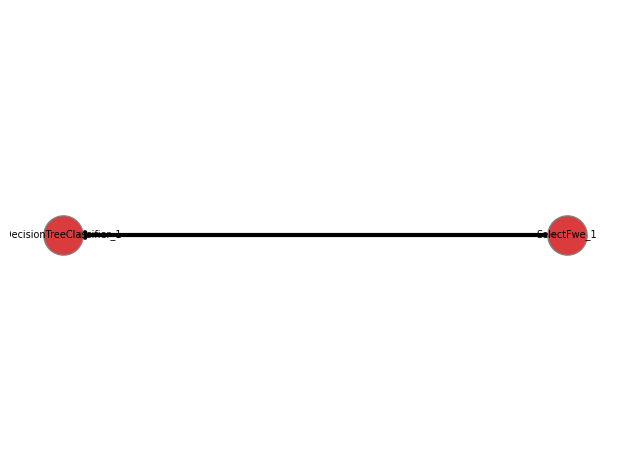

In [37]:
est1 = ind.export_pipeline()
est1.plot() #GraphPipelines have a helpful plotting function to visualize the pipeline

Lets add a few more mutations and plot the final pipeline to get a sense of the diversity of pipelines that can be generated with this search space

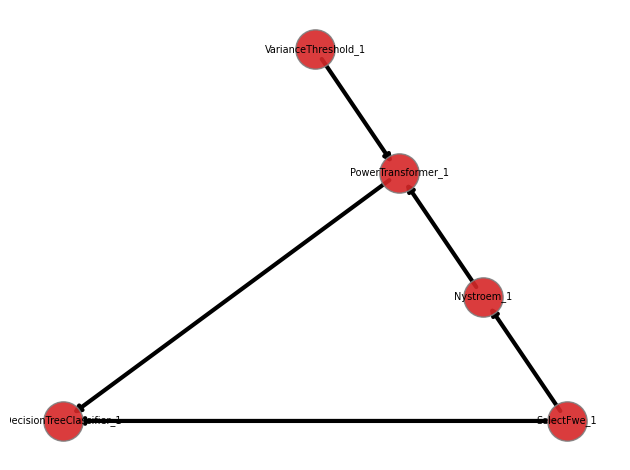

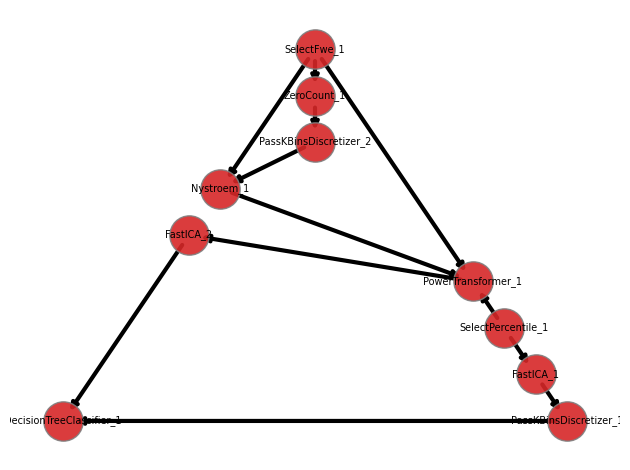

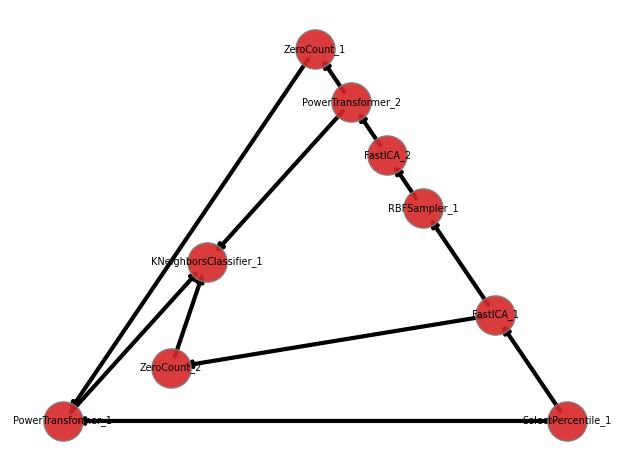

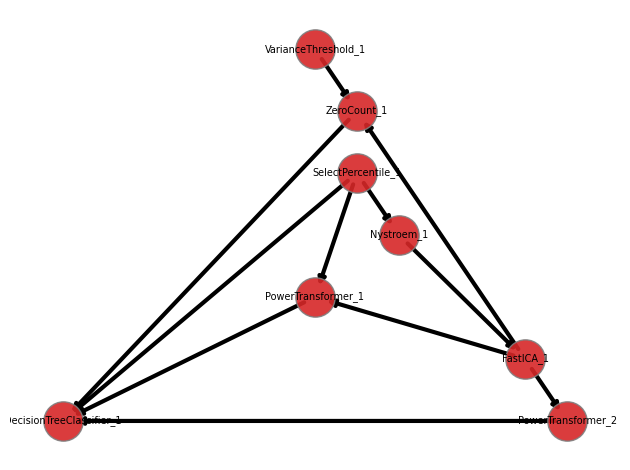

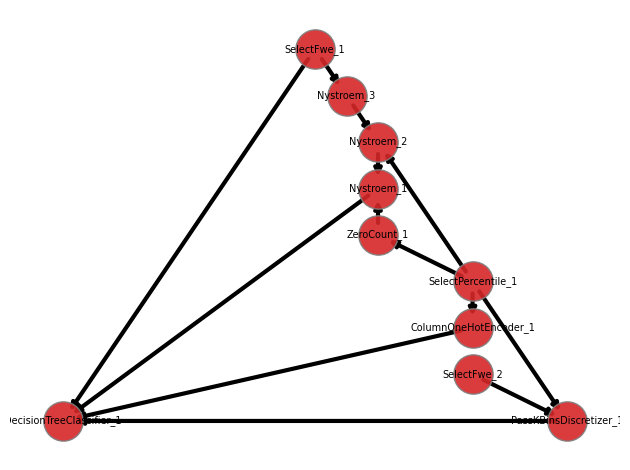

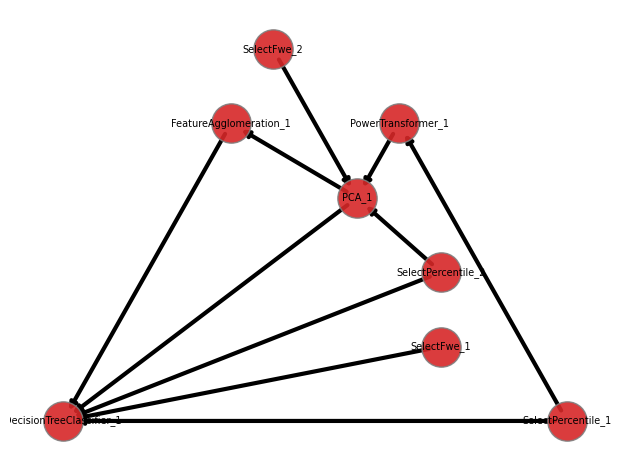

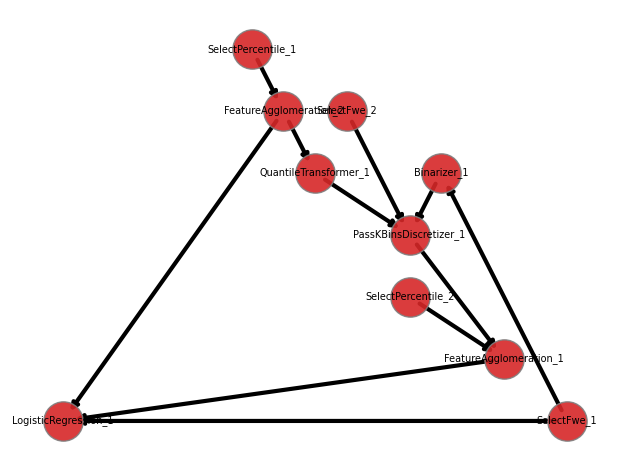

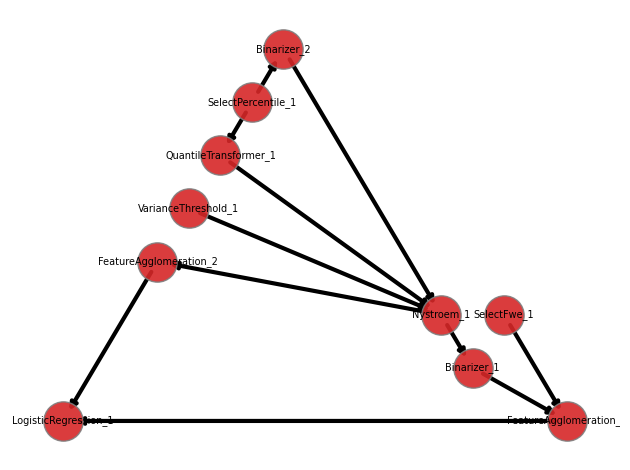

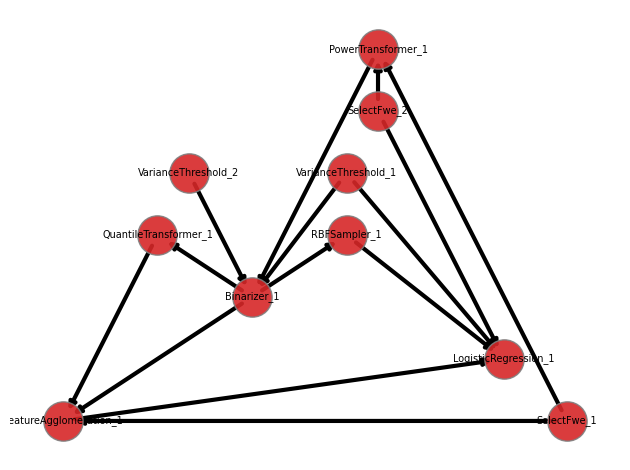

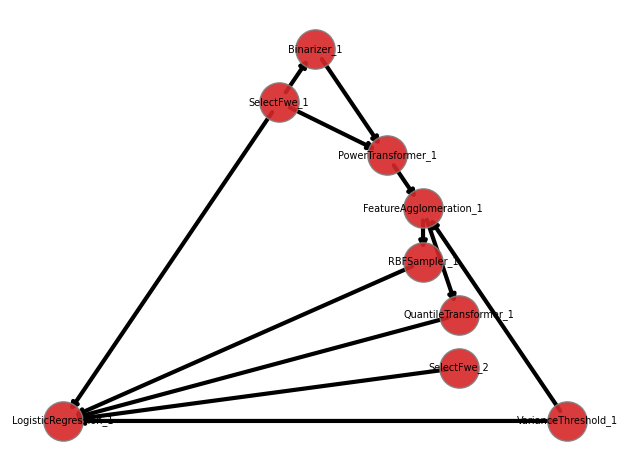

In [38]:
for i in range(0,50):
    ind.mutate()
    if i%5==0:
        est = ind.export_pipeline()
        est.plot()

### TreePipeline

TreePipelines work the same way as GraphPipelines, but they are limited to a tree structure. This is similar to the search space in the original TPOT.

(This search space is still experimental and currently built off GraphSearchPipeline. It may be rewritten with its own code in the future.)

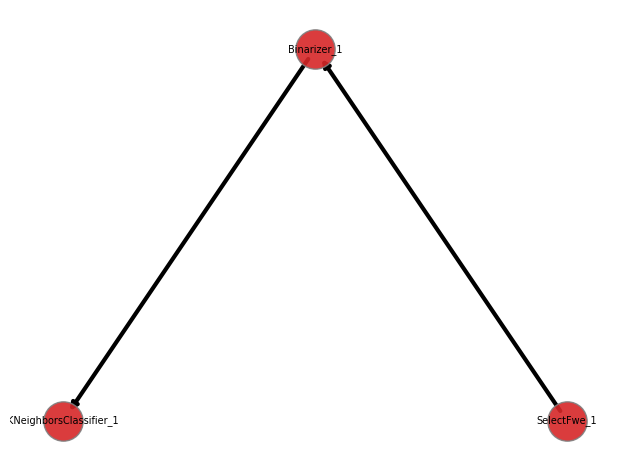

In [39]:
tree_search_space = tpot2.search_spaces.pipelines.TreePipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = tpot2.config.get_search_space("selectors"), 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

ind = graph_search_space.generate()
exp = ind.export_pipeline()
exp.plot()

## Tips and Tricks

* Two very helpful transformers to use with search spaces are tpot2.buildin_models.Passthrough and tpot2.builtin_models.SkipTransformer. 
  Passthrough will simply pass through the exact inputs it receives into the next step. This is particularly useful inside UnionSearchSpace as it allows for both the transformed data as well as the original data to be passed into the next step.
  SkipTransformer will always return nothing. This is helpful when inside a union with Passthrough and an optional second method. For example, if you are unsure of whether or not you will need a transformer, you can have SkipTransformer be one option that will skip the transformation step if selected.

In this example, the FeatureUnion layer will always have at least one transformer selected and will always have one passthrough

In [46]:
from tpot2.search_spaces.pipelines import *
from tpot2.config import get_search_space

#This FeatureUnion layer will always have at least one transformer selected and will always have one passthrough
transformers_with_passthrough = UnionPipeline([
                        DynamicUnionPipeline(get_search_space(["transformers"])),
                        get_search_space("Passthrough")
                        ]
                    )

transformers_with_passthrough.generate().export_pipeline()

FeatureUnion(transformer_list=[('featureunion',
                                FeatureUnion(transformer_list=[('powertransformer',
                                                                PowerTransformer()),
                                                               ('passkbinsdiscretizer',
                                                                PassKBinsDiscretizer(n_bins=11,
                                                                                     strategy='uniform'))])),
                               ('passthrough', Passthrough())])

In this example, the FeatureUnion layer will always one passthrough. In addition, it may select one or more transformer, but it may skip transformers altogether and only include a Passthrough. 

In [47]:
final_transformers_layer =UnionPipeline([
                        ChoicePipeline([
                            DynamicUnionPipeline(get_search_space(["transformers"])),
                            get_search_space("SkipTransformer"),
                        ]),
                        get_search_space("Passthrough")
                        ]
                    )

final_transformers_layer.generate().export_pipeline()

FeatureUnion(transformer_list=[('skiptransformer', SkipTransformer()),
                               ('passthrough', Passthrough())])

In [52]:
inner_estimators_layer = UnionPipeline([
                            ChoicePipeline([
                                DynamicUnionPipeline(wrapped_estimators, max_estimators=4),
                                get_search_space("SkipTransformer"),
                            ]),
                            get_search_space("Passthrough")]
                        )

inner_estimators_layer.generate().export_pipeline()

FeatureUnion(transformer_list=[('featureunion',
                                FeatureUnion(transformer_list=[('estimatortransformer-1',
                                                                EstimatorTransformer(cross_val_predict_cv=10,
                                                                                     estimator=RandomForestClassifier(criterion='entropy',
                                                                                                                      max_features=0.0291036830622,
                                                                                                                      min_samples_leaf=10,
                                                                                                                      min_samples_split=20,
                                                                                                                      n_estimators=128),
                                                                                     method='predict')),
                                                               ('estimatortransformer-2',
                                                                EstimatorTransformer(cross_val_predict_cv=10,
                                                                                     estimator=QuadraticDiscriminantAnalysis(reg_param=0.6791389504331),
                                                                                     method='predict')),
                                                               ('estimatortransformer-3',
                                                                EstimatorTransformer(cross_val_predict_cv=10,
                                                                                     estimator=QuadraticDiscriminantAnalysis(reg_param=0.8087868529112),
                                                                                     method='predict'))])),
                               ('passthrough', Passthrough())])

In [53]:
final_linear_pipeline = SequentialPipeline([
                            get_search_space("scalers"),
                            final_transformers_layer,
                            inner_estimators_layer,
                            get_search_space("classifiers"),
                        ])

final_linear_pipeline.generate().export_pipeline()

Pipeline(steps=[('robustscaler',
                 RobustScaler(quantile_range=(0.1562687943568,
                                              0.8028910581685))),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('baggingclassifier',
                 BaggingClassifier(bootstrap_features=True,
                                   max_features=0.1392808422872,
                                   max_samples=0.5344888038724, n_estimators=3,
                                   n_jobs=1, oob_score=True))])

# Optimize Search Space with TPOTEstimator

Once you have constructed a search space, you can use TPOTEstimator to optimize a pipeline within that space. Simply pass that search space into the `search_space` parameter. Here is a cell where you can select different search spaces that we created in this tutorial.

In [55]:
all_search_spaces ={
    "classifiers_only" : classifier_choice,
    "stc_pipeline" : stc_pipeline,
    "stc_pipeline2": stc_pipeline2,
    "stc_pipeline3": stc_pipeline3,
    "stc_pipeline4": stc_pipeline4,
    "final_linear_pipeline": final_linear_pipeline,
    "graph_pipeline": graph_search_space,
}

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

In [62]:
selected_search_space = all_search_spaces["stc_pipeline"] #change this to select a different search space


est = tpot2.TPOTEstimator(
    scorers=["roc_auc_ovr", tpot2.objectives.complexity_scorer],
    scorers_weights=[1.0, -1.0],
    classification = True,
    cv = 5,
    search_space = selected_search_space,
    population_size= 50,
    generations = 5,
    max_eval_time_mins = 10,
    early_stop = 2,
    verbose = 2,
    n_jobs=4,
)

est.fit(X_train, y_train)

/home/perib/miniconda3/envs/myenv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40273 instead
  warnings.warn(


Generation:  60%|██████    | 3/5 [00:44<00:29, 14.98s/it]
/home/perib/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (688) is greater than the total number of samples (284). n_quantiles is set to n_samples.
  warnings.warn(


TPOTEstimator(classification=True, cv=5, early_stop=2, generations=5,
              max_eval_time_mins=10, n_jobs=4,
              scorers=['roc_auc_ovr',
                       <function complexity_scorer at 0x7e7bacf5b9a0>],
              scorers_weights=[1.0, -1.0],
              search_space=<tpot2.search_spaces.pipelines.sequential.SequentialPipeline object at 0x7e7ba3b078b0>,
              verbose=2)

In [68]:
# score the model
auroc_scorer = sklearn.metrics.get_scorer("roc_auc")
auroc_score = auroc_scorer(est, X_test, y_test)

print("auroc score", auroc_score)

auroc score 0.9845976642022929


In [69]:
#plot the best pipeline
if isinstance(est.fitted_pipeline_, tpot2.GraphPipeline):
    est.fitted_pipeline_.plot()
    
est.fitted_pipeline_

Pipeline(steps=[('variancethreshold',
                 VarianceThreshold(threshold=0.0003237844275)),
                ('quantiletransformer', QuantileTransformer(n_quantiles=688)),
                ('baggingclassifier',
                 BaggingClassifier(bootstrap_features=True,
                                   max_features=0.2631592196919,
                                   max_samples=0.488886320861, n_estimators=72,
                                   n_jobs=1))])

## Template Search Spaces

As mentioned in Tutorial 1, TPOT has several buildin search spaces. Here is the same table:

| String     | Description      |
| :---        |    :----:   |
| linear  | A linear pipeline with the structure of "Selector->(transformers+Passthrough)->(classifiers/regressors+Passthrough)->final classifier/regressor." For both the transformer and inner estimator layers, TPOT may choose one or more transformers/classifiers, or it may choose none. The inner classifier/regressor layer is optional. |
| linear-light | Same search space as linear, but without the inner classifier/regressor layer and with a reduced set of faster running estimators. |
| graph | TPOT will optimize a pipeline in the shape of a directed acyclic graph. The nodes of the graph can include selectors, scalers, transformers, or classifiers/regressors (inner classifiers/regressors can optionally be not included). This will return a custom GraphPipeline rather than an sklearn Pipeline. More details in Tutorial 6. |
| graph-light | Same as graph search space, but without the inner classifier/regressors and with a reduced set of faster running estimators. |
| mdr |TPOT will search over a series of feature selectors and Multifactor Dimensionality Reduction models to find a series of operators that maximize prediction accuracy. The TPOT MDR configuration is specialized for genome-wide association studies (GWAS), and is described in detail online here. |

Rather than create your own search space, you can simply pass the string into the `search_space` param. Alternatively, you can access tpot2.config.template_search_spaces.get_template_search_spaces directly which offers a few more customizable options for each template including `cross_val_predict_cv` and whether or not stacked classifiers/regressors are allowed. Or you can copy the code and customize it manually!

# Combined Search Space Example

In [ ]:
from tpot2.search_spaces.pipelines import *
from tpot2.config import get_search_space

selectors = get_search_space(["selectors_classification", "Passthrough"])
estimators = get_search_space(["classifiers"])


# this allows us to wrap the classifiers in the EstimatorTransformer
# this is necessary so that classifiers can be used inside of sklearn pipelines
wrapped_estimators = WrapperPipeline(tpot2.builtin_modules.EstimatorTransformer, {}, estimators)

scalers = get_search_space(["scalers","Passthrough"])

transformers_layer =UnionPipeline([
                        ChoicePipeline([
                            DynamicUnionPipeline(get_search_space(["transformers"])),
                            get_search_space("SkipTransformer"),
                        ]),
                        get_search_space("Passthrough")
                        ]
                    )

inner_estimators_layer = UnionPipeline([
                            ChoicePipeline([
                                DynamicUnionPipeline(wrapped_estimators),
                                get_search_space("SkipTransformer"),
                            ]),
                            get_search_space("Passthrough")]
                        )


search_space = SequentialPipeline(search_spaces=[
                                        scalers,
                                        selectors, 
                                        transformers_layer,
                                        inner_estimators_layer,
                                        estimators,
                                        ])

est = tpot2.TPOTEstimator(
    scorers = ["roc_auc"],
    scorers_weights = [1],
    classification = True,
    cv = 5,
    search_space = search_space,
    population_size= 10,
    generations = 5,
    max_eval_time_mins = 60*5,
    verbose = 2,
)

est.fit(X_train, y_train)

In [ ]:
est.fitted_pipeline_